In [1]:
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import make_interp_spline
from matplotlib import colors
import os
import io

In [84]:
source = Image.open('input/frog.png')
secret = Image.open('input/field.jpg')

In [85]:
source_ratio = source.size[0] / source.size[1]
secret_ratio = secret.size[0] / secret.size[1]

if secret_ratio > source_ratio:
    secret = secret.resize((int(source.size[1] * secret_ratio),
                           source.size[1]))
    crop_x = round(secret.size[0] / 2 - source.size[0] / 2)
    secret = secret.crop((crop_x, 
                          0, 
                          crop_x + source.size[0], 
                          secret.size[1]))
else:
    secret = secret.resize((source.size[0], 
                            int(source.size[0] / secret_ratio)))
    crop_y = round(secret.size[1] / 2 - source.size[1] / 2)
    secret = secret.crop((0,
                          crop_y, 
                          secret.size[0], 
                          crop_y + source.size[1]))

In [69]:
# (1080, 1080, 3)

In [74]:
source_np.shape

(1600, 2560, 3)

In [100]:
%%time

source_np = np.array(source)[:,:,:3]
secret_np = np.array(secret)[:,:,:3]

gs = np.array([0.2126, 0.7152, 0.0722])
gs = np.array([0.299, 0.587, 0.114])

for i in range(source_np.shape[0]):
    for j in range(source_np.shape[1]):
        # target = (secret_np[i][j] / 255) @ gs
        target = 0.5
        old_rgb = source_np[i][j] / 255
        delta = gs * (gs @ old_rgb - target) / (gs @ gs)
        new_rgb = old_rgb - delta
        new_rgb = np.clip(new_rgb, 0, 1)
        source_np[i][j] = new_rgb * 255

CPU times: user 17.5 s, sys: 145 ms, total: 17.7 s
Wall time: 18.3 s


In [152]:
source_np = np.array(source)[:,:,:3]
secret_np = np.array(secret)[:,:,:3]

gs = np.array([0.2126, 0.7152, 0.0722])
# gs = np.array([0.299, 0.587, 0.114])

target = 0.5
# target = (secret_np / 255) @ gs

old_rgb = source_np / 255
delta = gs * np.expand_dims(old_rgb @ gs - target, -1) / (gs @ gs)
new_rgb = old_rgb - delta
new_rgb = np.clip(new_rgb, 0, 1) * 255
source_np = new_rgb.astype('uint8')

In [194]:
def get_borders(color):
    r, g, b = color
    return np.array(
        [[ -r,   0,   0], 
         [1-r,   0,   0],
         [  0,  -g,   0],
         [  0, 1-g,   0],
         [  0,   0,  -b],
         [  0,   0, 1-b]]
    )

def get_matrix(grayscale):
    r, g, b = grayscale
    return np.array(
        [[g*g+b*b,    -r*g,    -r*b], 
         [   -r*g, r*r+b*b,    -g*b], 
         [   -r*b,    -g*b, r*r+g*g]]
    )

color = np.array([0.1, 0.9, 0.1])
gs = np.array([0.2, 0.3, 0.5])
target = 0.7

borders = get_borders(color)
alphas = np.sum(borders, axis=-1)
ks = borders.astype(bool).astype(int)
matrix = get_matrix(gs)
ms = borders @ matrix
bc = -gs * (gs @ color - target) / (gs @ gs)
dots = ms * np.expand_dims(alphas - ks @ bc, -1) / (np.expand_dims(ks, -2) @ np.expand_dims(ms, -1)).reshape((6, 1)) + bc

dots

array([[-0.1       ,  0.33529412,  0.55882353],
       [ 0.9       ,  0.15882353,  0.26470588],
       [ 0.43448276, -0.9       ,  1.0862069 ],
       [ 0.22758621,  0.1       ,  0.56896552],
       [ 0.63076923,  0.94615385, -0.1       ],
       [-0.13846154, -0.20769231,  0.9       ]])

In [197]:
np.sum(dots ** 2, axis=-1)

array([0.43470588, 0.90529412, 2.17862069, 0.38551724, 1.30307692,
       0.87230769])

In [155]:
r, g, b = 0.2, 0.3, 0.5
np.dot([0, 0.1, 0], [[g*g+b*b, -r*g, -r*b], [-r*g, r*r+b*b, -g*b], [-r*b, -g*b, r*r+g*g]])

array([-0.006,  0.029, -0.015])

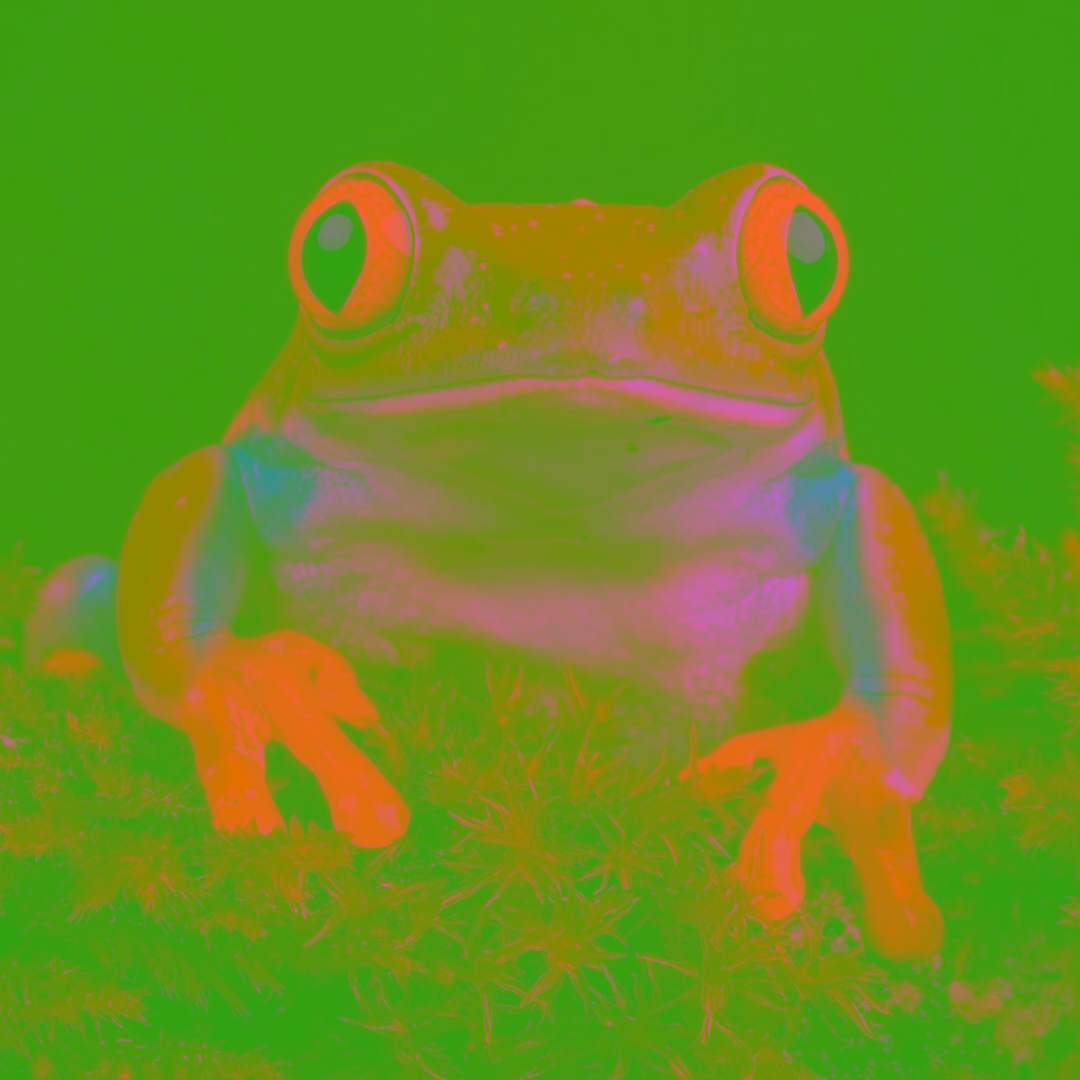

In [153]:
Image.fromarray(source_np)#.convert('L')

In [132]:
Image.fromarray(source_np)#.convert('L')

TypeError: Cannot handle this data type: (1, 1, 3), <f8